# Import libraries

In [1]:
import pandas as pd
from imgix import UrlBuilder
from google.cloud import vision
from google.oauth2 import service_account
import os
import lzma
import json
from sklearn.decomposition import LatentDirichletAllocation
from gensim import corpora, models
from gensim.matutils import Sparse2Corpus
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models.ldamodel import LdaModel
from sklearn.metrics.pairwise import cosine_similarity

# Import Google Cloud credentials

In [2]:
# Path to your service account key file
key_path = "/Users/qianlou/Documents/GitHub/Social-Media-Analysis/forward-cacao-420716-6d4b68655e6d.json"

# Set up Google Vision client
credentials = service_account.Credentials.from_service_account_file(key_path)
# Initialize the Vision API Client
client = vision.ImageAnnotatorClient(credentials=credentials)

def detect_labels(image_path):
    """Detect labels in the image at the given path using Google Vision API."""
    with open(image_path, 'rb') as image_file:
        content = image_file.read()
    image = vision.Image(content=content)
    response = client.label_detection(image=image)
    return [label.description for label in response.label_annotations]

def find_key(data, target_key):
    """Recursively search for a key in JSON data."""
    if isinstance(data, dict):
        for key, value in data.items():
            if key == target_key:
                return value
            result = find_key(value, target_key)
            if result:
                return result
    elif isinstance(data, list):
        for item in data:
            result = find_key(item, target_key)
            if result:
                return result

# Import Data

URL Link: https://www.kaggle.com/datasets/thecoderenroute/instagram-posts-dataset?resource=download

In [44]:
data_folder_path = '/Users/qianlou/Documents/GitHub/Social-Media-Analysis/Data'

data = []  # List to hold all data extracted and processed

# Walk through the directory structure
for root, dirs, files in os.walk(data_folder_path):
    folder_name = os.path.basename(root)
    parts = folder_name.rsplit('_', 4)  # Split from the right to capture the last four elements distinctly
    
    if len(parts) < 5:
        continue  # Skip folders that do not have the expected number of parts

    profile_name = parts[0]  # Everything before the last four parts is the profile name
    follower_count, post_id, likes, comments = parts[1:]  # Unpack the last four parts in order
    
    all_labels = []
    json_data = {}

    for file in files:
        file_path = os.path.join(root, file)
        if file.endswith('.json.xz'):
            with lzma.open(file_path, 'rt') as json_file:
                json_data = json.load(json_file)
        elif file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_labels = detect_labels(file_path)
            all_labels.extend(image_labels)

    engagement_score = find_key(json_data, 'edge_media_to_comment')
    engagement_count = engagement_score.get('count') if engagement_score and isinstance(engagement_score, dict) and 'count' in engagement_score else None

    if all_labels:
        data.append({
            'profile_name': profile_name,
            'follower_count': follower_count,
            'post_id': post_id,
            'likes': likes,
            'comments': comments,
            'labels': ' '.join(all_labels),
            'engagement_score': engagement_count
        })

# Convert the list of data into a DataFrame
df = pd.DataFrame(data)

In [64]:
df.to_csv('data.csv', index=False)

# Read Again

In [3]:
df = pd.read_csv('data.csv')

In [4]:
df.head(5)

,profile_name,follower_count,post_id,likes,comments,labels,engagement_score
0,zomato,809822,3048876535670217534,22392,177,Food Ingredient Recipe Natural foods Cuisine D...,177
1,zomato,809822,3030021979666495337,17536,256,Rectangle Font Magenta Screenshot Parallel Num...,256
2,zomato,809822,3017722431480959941,6778,134,Font Screenshot Terrestrial plant Rectangle Nu...,134
3,zomato,809822,3058297827754329035,346067,1603,Bird Organism Beak Adaptation Terrestrial anim...,1603
4,zomato,809822,3053234851745688757,30434,142,Smile Product Happy Kitchen appliance Tablewar...,142


# Topic Modeling - Find the best number of topics

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


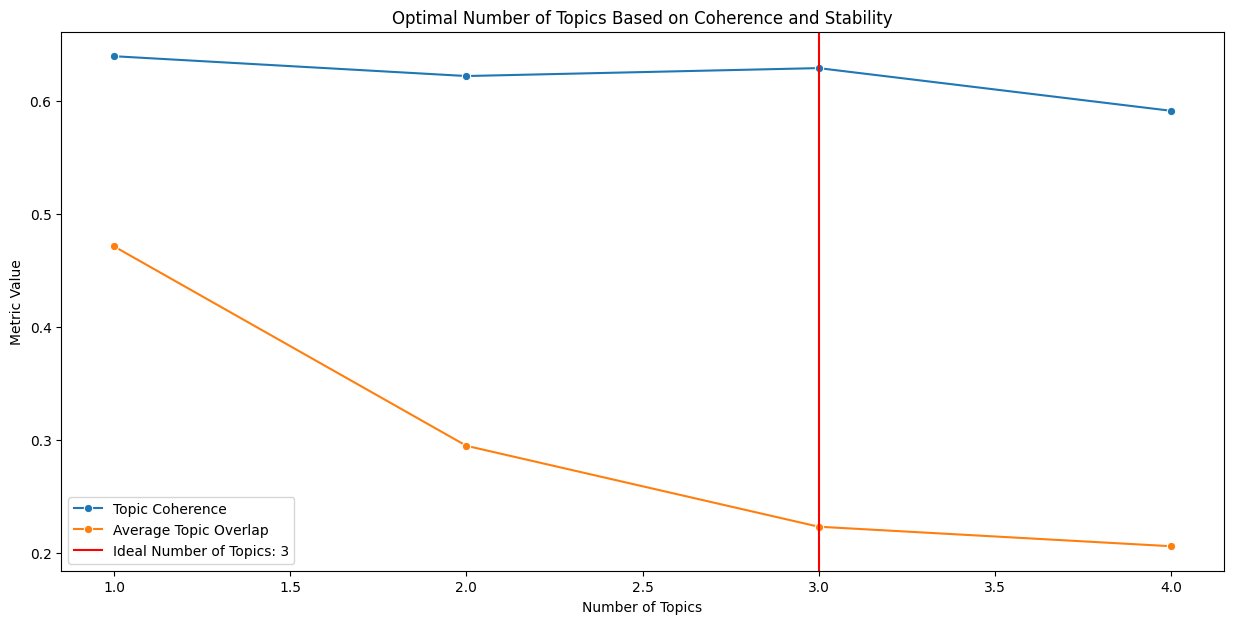

In [9]:
# Prepare data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english', tokenizer=lambda text: text.split())
data_vectorized = vectorizer.fit_transform(df['labels'])

# Compute LDA Models
LDA_models = {n_topics: LatentDirichletAllocation(n_components=n_topics, random_state=42).fit(data_vectorized)
              for n_topics in range(1, 6)}

# Prepare for coherence calculations
texts = [text.split() for text in df['labels']]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Calculate Coherence and handle possible errors
coherences = {}
for n_topics, model in LDA_models.items():
    topics = []
    for topic_idx, topic_dist in enumerate(model.components_):
        topic_terms = topic_dist.argsort()[-26:][::-1]
        topic_words = [dictionary[id] for id in topic_terms if id < len(dictionary)]
        topics.append(topic_words)
    if topics:
        coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence = coherence_model.get_coherence()
        coherences[n_topics] = coherence

# Calculate Jaccard similarity for topic stability
def jaccard_similarity(topic_1, topic_2):
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
    return float(len(intersection)) / float(len(union))

LDA_stability = {}
num_keywords = 26
for i in range(1, 5):  
    jaccard_sims = []
    current_topics = [set(top.argsort()[-num_keywords:]) for top in LDA_models[i].components_]
    next_topics = [set(top.argsort()[-num_keywords:]) for top in LDA_models[i + 1].components_]
    for current_topic in current_topics:
        sims = [jaccard_similarity(current_topic, next_topic) for next_topic in next_topics]
        jaccard_sims.append(sims)
    LDA_stability[i] = np.mean(jaccard_sims)

# Combine coherence and stability to determine the ideal number of topics
coh_sta_diffs = [coherences[i] - LDA_stability[i] for i in range(1, 5)]
ideal_topic_num_index = np.argmax(coh_sta_diffs)
ideal_topic_num = ideal_topic_num_index + 1  # Adjusting for zero index

# Plot results
plt.figure(figsize=(15, 7))
sns.lineplot(x=list(range(1, 5)), y=[coherences[i] for i in range(1, 5)], label='Topic Coherence', marker='o')
sns.lineplot(x=list(range(1, 5)), y=[LDA_stability[i] for i in range(1, 5)], label='Average Topic Overlap', marker='o')
plt.axvline(x=ideal_topic_num, label=f'Ideal Number of Topics: {ideal_topic_num}', color='red')
plt.title('Optimal Number of Topics Based on Coherence and Stability')
plt.xlabel('Number of Topics')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

## Best number of topics is 3, Re-run LDA with 3 topics

In [26]:
# Convert image labels to a matrix of token counts
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english', tokenizer=lambda text: text.split())
X = vectorizer.fit_transform(df['labels'])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=3, random_state=0)  
topics = lda.fit_transform(X)

# Display top 25 words for each topic
features = vectorizer.get_feature_names_out()
top_words = lambda t: [features[i] for i in np.argsort(t)[:-26:-1]]
topic_words = {i: top_words(t) for i, t in enumerate(lda.components_)}

print(topic_words[0])
print(topic_words[1])
print(topic_words[2])

['font', 'automotive', 'vehicle', 'tire', 'design', 'blue', 'car', 'electric', 'wheel', 'brand', 'rectangle', 'motor', 'circle', 'logo', 'lighting', 'event', 'hood', 'graphics', 'number', 'screenshot', 'advertising', 'magenta', 'sky', 'poster', 'art']
['sports', 'food', 'ingredient', 'tableware', 'jersey', 'recipe', 'cuisine', 'uniform', 'player', 'baseball', 'dish', 'equipment', 'gesture', 'plate', 'cap', 'dishware', 'gear', 'produce', 'vegetable', 'shorts', 'baked', 'goods', 'ball', 'staple', 'event']
['fashion', 'smile', 'sleeve', 'happy', 'photography', 'flash', 'design', 'waist', 'thigh', 'plant', 'shoulder', 'dress', 'sky', 'hair', 'gesture', 'leisure', 'neck', 'eyewear', 'event', 'people', 'fun', 'human', 'leg', 'joint', 'nature']


## Interpretation of the topics

1. **Automotive Design**: This topic seems to revolve around automotive-related terms like "vehicle," "car," "electric," "wheel," and "logo," suggesting discussions or images related to automotive design and branding.

2. **Sports and Food**: This topic appears to encompass terms related to both sports and food, including "sports," "food," "jersey," "recipe," "cuisine," "player," "dish," "gear," and "vegetable," indicating content related to sports events, food recipes, or possibly sports nutrition.

3. **Fashion and Photography**: This topic includes terms related to fashion, photography, and leisure activities, such as "fashion," "smile," "photography," "dress," "hair," "leisure," and "eyewear," indicating content related to fashion trends, photography, and leisure activities.

## Calculate average topic weights for each quartile

In [28]:
topic_names = {
    0: "Automotive Design",
    1: "Sports and Food",
    2: "Fashion and Photography"
}

df_sorted = df.sort_values(by='comments', ascending=False)

# Divide the data into quartiles
num_images = len(df_sorted)
quartile_size = num_images // 4
last_quartile = df_sorted[:quartile_size]  # Highest quartile
first_quartile = df_sorted[-quartile_size:]  # Lowest quartile

# Convert image labels to a matrix of token counts for both quartiles
X_first = vectorizer.transform(first_quartile['labels'])
X_last = vectorizer.transform(last_quartile['labels'])

# Get topic distributions for each quartile
topics_first = lda.transform(X_first)
topics_last = lda.transform(X_last)

# Calculate average topic weights for each quartile
avg_weights_first = topics_first.mean(axis=0)
avg_weights_last = topics_last.mean(axis=0)

# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'Topic': [topic_names[i] for i in range(3)],
    'Avg Weight - First Quartile': avg_weights_first,
    'Avg Weight - Last Quartile': avg_weights_last
})

results_df

,Topic,Avg Weight - First Quartile,Avg Weight - Last Quartile
0,Automotive Design,0.227844,0.155931
1,Sports and Food,0.176928,0.250905
2,Fashion and Photography,0.595228,0.593164


# Suggestion for the influencer

Based on the analysis of the Instagram image labels and engagement metrics across multiple users, it's clear that certain topics attract more interest and engagement than others. These topics include **Automotive Design**, **Sports and Food**, and **Fashion and Photography**, each appealing to different segments of your audience. The data indicates varying levels of engagement across different quartiles, highlighting areas where adjustments to your content strategy could potentially enhance overall engagement.

To improve engagement across the influencer's Instagram page, it's advisable to tailor the content strategy to cater to the interests of the diverse audience. Firstly, given the consistent engagement observed for Fashion and Photography content across all quartiles, it would be prudent to continue producing visually captivating and high-quality posts in this category. Additionally, leveraging user-generated content or collaborations with influencers within the fashion and photography niche can further enhance engagement and community involvement.

Conversely, topics such as Automotive Design may benefit from a more targeted approach to re-engage users in the last quartile. This could involve diversifying content to include a mix of informative posts, behind-the-scenes looks, or interactive content such as polls or Q&A sessions to reignite interest and encourage active participation from users interested in automotive-related content.

By analyzing engagement patterns across different topics and user segments, the influencer can refine the content strategy to better align with the preferences and interests of the audience, ultimately fostering a more engaged and interactive community on the Instagram page.